# Clean Slate: Estimating offenses eligible for expungement under varying conditions
> Prepared by [Laura Feeney](https://github.com/laurafeeney) for Code for Boston's [Clean Slate project](https://github.com/codeforboston/clean-slate).

## Purpose
This notebook takes somewhat processed data from the Northwestern DA and answers the following questions, posed June 28, 2020. 

This analysis will be run a number of times: under existing regulation, and under varying conditions allowing additional offenses to be expunged.


1. How many people (under age 21) are eligible for expungement today? This would be people with only **one charge** that is not part of the list of ineligible offenses (per section 100J). 


2. How many people (under age 21) would be eligible based on only having **one incident** (which could include multiple charges) that are not part of the list of ineligible offenses?
 - How many people (under age 21) would be eligible based on only having **one incident** if only sex-based offenses or murder were excluded from expungement?
 

3. How many people (under age 21) would be eligible based on who has **not been found guilty** (given current offenses that are eligible for expungement)?
 - How many people (under age 21) would be eligible based on who has **not been found guilty** for all offenses except for murder or sex-based offenses?

-----

### Step 0
Import data, programs, etc.

-----

In [1]:
import pandas as pd
pd.set_option("display.max_rows", 200)
import numpy as np
import regex as re
import glob, os
import datetime 
from datetime import date 
from collections import defaultdict, Counter

In [2]:
# processed individual-level data from NW district with expungability.

nw = pd.read_csv('../../data/processed/merged_nw.csv', encoding='cp1252',
                    dtype={'Analysis notes':str, 'extra_criteria':str, 'Expungeable': str}) 

nw['Expungeable'].value_counts(dropna=False)


Yes              55052
No               20013
NotApplicable      439
Attempt            220
NaN                  1
Name: Expungeable, dtype: int64

## Step 1
Add a few additional variables needed, look at summary stats

There are many offenses that are violations of the Code of Massachusetts Regulations (CMR) rather than a criminal offense. These include things like some driving or boating infractions (e.g., not having headlights on), or not having a hunting/fishing license. It's not clear whether these should be included at all. We'll run the analysis first including them at all stages, and then excluding them at all stages. 

In [3]:
### dates ###

reference_date = datetime.date(2020, 9, 1) # using "today.date() wouldn't be stable"

nw['Offense Date'] = pd.to_datetime(nw['Offense Date']).dt.date
nw['years_since_offense'] = (reference_date - nw['Offense Date'])/pd.Timedelta(1, 'D')/365

nw[nw['Offense Date']<datetime.date(1950, 1, 1)]

print("The earliest offense date is", min(nw['Offense Date']))
print("The max offense date is", max(nw['Offense Date']), "\n")

print(nw['years_since_offense'].describe())

print("\n There are a tail of dates that are probably wrong, but age is missing for most anyways,"
      + "so we typically exclude offenses without an age")

The earliest offense date is 1750-12-03
The max offense date is 2018-12-30 

count    74915.000000
mean         4.460396
std          2.798864
min          1.673973
25%          3.060274
50%          4.328767
75%          5.638356
max        269.926027
Name: years_since_offense, dtype: float64

 There are a tail of dates that are probably wrong, but age is missing for most anyways,so we typically exclude offenses without an age


In [4]:
# CMR: Drop all CMR offenses and Drop CMR-related columns

print(f'There are {nw.shape[0]} total offenses including CMR.')

nw = nw.loc[nw['CMRoffense'] == 'no']
nw = nw.drop(columns = ['CMRoffense'])

print(f'After we drop CMR, there are {nw.shape[0]} total offenses.')

There are 75725 total offenses including CMR.
After we drop CMR, there are 75285 total offenses.


In [5]:
# distribution of # of charges

nw['num_offenses']=nw.groupby('Person ID')['Person ID'].transform('count')
print(nw['num_offenses'].describe())

#nw.loc[nw['num_offenses']<30].hist(column='num_offenses', bins=15)

count    75285.000000
mean        10.075752
std         18.230430
min          1.000000
25%          3.000000
50%          5.000000
75%         11.000000
max        202.000000
Name: num_offenses, dtype: float64


In [46]:
### number of unique people, incidents, % under 21Number_Cases = ms['Case Number'].nunique()
Number_People = nw['Person ID'].nunique()
Number_Juvenile = nw[ (~nw['Age at Offense'].isnull()) & (nw['Age at Offense']<21)]['Person ID'].nunique()
Percent_Juvenile = "{:.2%}".format(Number_Juvenile/Number_People)
Number_Adult = nw[ (~nw['Age at Offense'].isnull()) & (nw['Age at Offense']>=21)]['Person ID'].nunique()

print('There are', Number_People, 'unique Person IDs in the Northwestern file. Of those,', Number_Juvenile,
      'ie' , Percent_Juvenile,
     'were under 21 at the offense date.')
print(f"There are {nw[nw['num_offenses']==1]['Person ID'].nunique()} people with only 1 offense")
print(f"This is {nw[nw['num_offenses']==1]['Person ID'].nunique() / Number_People:.2%} of the individuals")

There are 19686 unique Person IDs in the Northwestern file. Of those, 2854 ie 14.50% were under 21 at the offense date.
There are 5026 people with only 1 offense
This is 25.53% of the individuals


In [35]:
print(nw['Expungeable'].value_counts())

Yes        55052
No         20013
Attempt      220
Name: Expungeable, dtype: int64


In [44]:
#Data prep

#Number of incidents (separate offense dates per same ID)
nw['Incidents'] = (nw.groupby('Person ID')['Offense Date'].transform('nunique'))

# If an incident includes one offense that is not expungeable, we mark the entire incident as not expungeable.
#Attempts *are not* considered expungeable in this one. 
nw['Exp'] = nw['Expungeable']=="Yes"
nw['Inc_Expungeable_Attempts_Not'] = nw.groupby(['Person ID', 'Offense Date'])['Exp'].transform('min')

# If an incident includes one offense that is not expungeable, we mark the entire incident as not expungeable.
#Attempts *are* not considered expungeable in this one. 
nw['ExpAtt'] = (nw['Expungeable']=="Yes") | (nw['Expungeable']=="Attempt")
nw['Inc_Expungeable_Attempts_Are'] = nw.groupby(['Person ID', 'Offense Date'])['ExpAtt'].transform('min')

# If an incident includes an offense that is a murder and/or sex crime, we code the whole incident as regarding
# murder and/or sex.
nw['sm'] = (nw['sex'] == 1) | (nw['murder'] ==1)
nw['Incident_Murder_Sex'] = nw.groupby(['Person ID', 'Offense Date'])['sm'].transform('max')

#Sanity check to make sure I coded things right
#nw[['Person ID', 'Offense Date', 'murder', 'sex', 'Incident_Murder_Sex']][100:2000].loc[nw['Incident_Murder_Sex'] == 1]

#unneeded calculation columns
nw = nw.drop(columns=['Exp', 'sm'])

## Question 1
- How many people are eligible for expungement today? 
    - ---> *Only one charge*, Offense committed before 21st birthday, charge is not part of the list of ineligible offenses (per section 100J), charge is in the correct timeframe from today's date

We don't have misdemeanor / felony info, so will show the # that are more than 3 or more than 7 years from today.

----

In [37]:
def date_range(x):
    greater3 = x.loc[(x['years_since_offense'] > 3)]['Person ID'].nunique()
    greater7 = x.loc[(x['years_since_offense'] > 7)]['Person ID'].nunique()

    print(greater3, "occured more than 3 years before", reference_date)
    print(greater7, "occured more than 7 years before", reference_date)
    

In [39]:
eligible_all_ages = nw.loc[
    (nw['num_offenses']==1) &
    (nw['Expungeable'] != 'No') &
    (~nw['Age at Offense'].isnull())
]['Person ID'].nunique()

print("There are", eligible_all_ages, "individuals of any age with a single offense that is theoretically eligible for expungment.")
print(f"This is {eligible_all_ages / Number_People:.2%} of the individuals")

There are 3557 individuals of any age with a single offense that is theoretically eligible for expungment.
This is 18.07% of the individuals


In [55]:
x = nw.loc[
    (nw['num_offenses']==1) &
    (nw['Expungeable'] != 'No') &
    (~nw['Age at Offense'].isnull()) &
    (nw['Age at Offense']<21)
]

People_eligible = x['Person ID'].nunique()

print("There are", People_eligible,
      "people with charges eligible for expungement in the NW district of MA",
      "if we include 'attempts' as expungeable.")
print(f"This is {People_eligible / Number_Juvenile:.2%} of juveniles in the file.")

date_range(x)

print("\nDispositions: \n\n", x.Disposition.value_counts(dropna=False))

There are 549 people with charges eligible for expungement in the NW district of MA if we include 'attempts' as expungeable.
This is 19.24% of juveniles in the file.
392 occured more than 3 years before 2020-09-01
11 occured more than 7 years before 2020-09-01

Dispositions: 

 c276s87 finding                     154
Dismissed at Request of Comm         96
Responsible                          80
Nolle Prosequi                       50
Dismissed Prior to Arraignment       42
Dismissed                            32
Dismissed on Payment                 28
Continued w/o Finding                26
NaN                                  25
Guilty                                6
Dismissed by Court                    3
Delinquent                            3
Charge Handled as a Civil Charge      3
Responsible Filed                     1
Name: Disposition, dtype: int64


In [56]:
x = nw.loc[
    (nw['num_offenses']==1) &
    (nw['Expungeable'] == 'Yes') &
    (~nw['Age at Offense'].isnull()) &
    (nw['Age at Offense']<21) 
]

People_eligible = x['Person ID'].nunique()

print("There are", People_eligible,
      "people with charges eligible for expungement in the NW district of MA,",
      " if we assume all 'attempts' are not expungeable.")
#print(f"This is {People_eligible / Number_People:.2%} of the individuals including adults & juveniles")
#print(f"This is {People_eligible / Number_Juvenile:.2%} of the juveniles")

#date_range(x)

There are 547 people with charges eligible for expungement in the NW district of MA,  if we assume all 'attempts' are not expungeable.


## Question 2: incidents rather than offenses

Luke Schissler & Laura Feeney

2. How many people (under age 21) would be eligible based on only having **one incident** (which could include multiple charges) that are not part of the list of ineligible offenses?
 - 2a. How many people (under age 21) would be eligible based on only having **one incident** if only sex-based offenses or murder were excluded from expungement?


Making the assumption based on the 06/26/20 meeting notes that an 'incident' is defined as the sum of all charges for an individual on a single day. In theory, someone could probably be charged in two separate instances on a single day, but this is likely rare. 

For this analysis, we assume that a single non-expungeable offense under the bundle of the incident makes the entire incident non-expungeable. Same for the analysis of murder or sex crimes.

### How many people (under age 21) would be eligible based on only having one incident (which could include multiple charges) that are not part of the list of ineligible offenses?

In [61]:
# Find how many people whose offenses fall into a single incident, where all the offenses are expungeable 
# (Not including attempts). 

x = nw.loc[
    (nw['Incidents'] == 1) &
    (nw['Inc_Expungeable_Attempts_Not'] == True) &
    (~nw['Age at Offense'].isnull()) &
    (nw['Age at Offense']<21) 
]

People_eligible = x['Person ID'].nunique()

print("There are", People_eligible,
      "people with charges eligible for expungement in the NW district of MA, if the person has a single incident" +
      " in which all the offenses are expungeable" + 
     " if we consider attempts to be unexpungeable.")

print(f"This is {People_eligible / Number_Juvenile:.2%} of the juveniles")

date_range(x)

#print(x.sample(n=5)) # grab a random sample to verify
print("\nDispositions: \n\n", x.Disposition.value_counts(dropna=False))

There are 1247 people with charges eligible for expungement in the NW district of MA, if the person has a single incident in which all the offenses are expungeable if we consider attempts to be unexpungeable.
This is 43.69% of the juveniles
870 occured more than 3 years before 2020-09-01
27 occured more than 7 years before 2020-09-01

Dispositions: 

 Dismissed at Request of Comm        519
c276s87 finding                     455
Nolle Prosequi                      244
Responsible                         220
Continued w/o Finding               220
Not Responsible                     217
Dismissed Prior to Arraignment      156
Dismissed                           119
NaN                                 111
Dismissed on Payment                 92
Guilty                               36
Dismissed by Court                   14
Delinquent                           14
Responsible Filed                    13
Found Incompetent                     8
DYS Committed                         5
Charge

In [62]:
# Same as above, but make 'attempts' expungeable

x = nw.loc[
    (nw['Incidents'] == 1) &
    (nw['Inc_Expungeable_Attempts_Are'] == True) &
    (~nw['Age at Offense'].isnull()) &
    (nw['Age at Offense']<21) 
]

People_eligible = x['Person ID'].nunique()

print("There are", People_eligible,
      "people with charges eligible for expungement in the NW district of MA, if the person has a single incident," +
      " in which all the offenses are expungeable and attempts are considered expungeable.")

#date_range(x)

#print("\nDispositions: \n\n", x.Disposition.value_counts(dropna=False))

There are 1254 people with charges eligible for expungement in the NW district of MA, if the person has a single incident, in which all the offenses are expungeable and attempts are considered expungeable.


In [65]:
# Compare the above for adults.
#  how many adults  offenses fall into a single incident, where all the offenses are expungeable 
# (Not including attempts). 

x = nw.loc[
    (nw['Incidents'] == 1) &
    (nw['Inc_Expungeable_Attempts_Not'] == True) &
    (~nw['Age at Offense'].isnull()) &
    (nw['Age at Offense']>=21) 
]

People_eligible = x['Person ID'].nunique()

print("There are", People_eligible,
      "people with charges eligible for expungement in the NW district of MA, if the person has a single incident" +
      " in which all the offenses are expungeable" + 
     " if we consider attempts to be unexpungeable.")

print(f"This is {People_eligible / Number_Adult:.2%} of the adults")

#date_range(x)

print("\nTop 10 Dispositions: \n\n", x.Disposition.value_counts(dropna=False)[0:10])

There are 7152 people with charges eligible for expungement in the NW district of MA, if the person has a single incident in which all the offenses are expungeable if we consider attempts to be unexpungeable.
This is 41.60% of the adults

Top 10 Dispositions: 

 Dismissed at Request of Comm    3148
Not Responsible                 2147
Nolle Prosequi                  1355
NaN                             1281
Dismissed on Payment            1256
Responsible                     1200
Guilty                          1027
Dismissed                        848
Continued w/o Finding            775
c276s87 finding                  439
Name: Disposition, dtype: int64


### 2a - How many would be eligible if we only limited to only exclude sex-based offenses or murder?
**Limiting to those with one incident**

In [85]:
x = nw.loc[
    (nw['Incidents'] == 1) &
    (nw['Incident_Murder_Sex'] == 0) &
    (~nw['Age at Offense'].isnull()) &
    (nw['Age at Offense']<21) 
]

People_eligible = x['Person ID'].nunique()

print("There are", People_eligible,
      "people with charges eligible for expungement in the NW district of MA, if the person has a single incident" +
      " in which all offenses are unrelated to sex or murder")
print(f"This is {People_eligible / Number_Juvenile:.2%} of the juveniles")

date_range(x)

print("\nTop 10 Dispositions: \n\n", x.Disposition.value_counts(dropna=False)[0:10])

There are 1776 people with charges eligible for expungement in the NW district of MA, if the person has a single incident in which all offenses are unrelated to sex or murder
This is 62.23% of the juveniles
1256 occured more than 3 years before 2020-09-01
37 occured more than 7 years before 2020-09-01

Top 10 Dispositions: 

 Dismissed at Request of Comm      768
c276s87 finding                   677
Continued w/o Finding             470
Nolle Prosequi                    444
Not Responsible                   366
Responsible                       249
Dismissed Prior to Arraignment    197
Dismissed                         150
NaN                               147
Dismissed on Payment               96
Name: Disposition, dtype: int64


In [86]:
x = nw.loc[
    (nw['Incident_Murder_Sex'] == 0) &
    (~nw['Age at Offense'].isnull()) &
    (nw['Age at Offense']<21) 
]

People_eligible = x['Person ID'].nunique()

print("There are", People_eligible,
      "people with charges eligible for expungement in the NW district of MA, if the person has a *any* incident" +
      " in which all offenses are unrelated to sex or murder")
print(f"This is {People_eligible / Number_Juvenile:.2%} of the juveniles")

date_range(x)

print("\nTop 10 Dispositions: \n\n", x.Disposition.value_counts(dropna=False)[0:10])

There are 2802 people with charges eligible for expungement in the NW district of MA, if the person has a *any* incident in which all offenses are unrelated to sex or murder
This is 98.18% of the juveniles
2222 occured more than 3 years before 2020-09-01
72 occured more than 7 years before 2020-09-01

Top 10 Dispositions: 

 Dismissed at Request of Comm      1779
Continued w/o Finding             1769
c276s87 finding                   1301
Nolle Prosequi                    1280
Not Responsible                    759
Responsible                        512
Guilty                             470
Dismissed                          336
Dismissed Prior to Arraignment     278
NaN                                267
Name: Disposition, dtype: int64


## Question 3: Verdict as Determiner

**Question 3a** -  How many would be eligible based on who has not been found guilty (given current offenses that are eligible for expungement)?

Defining 'guilty' as one of these dispositions: 'Guilty', 'Guilty Filed', 'Guilty on Lesser Included Offense', 'c276s87 finding', 'Agreed Plea', 'Delinquent'

Need more work on this -- there are many dispositions that are null, and many others that indicate a case in process, transferred, etc, that would not indicate "guilty", but also would not indicate "not guilty"

In [91]:
# Guilty -- need more work here on which dispositions to include/excldue
guilty_dispos = ['Guilty', 'Guilty Filed', 'Guilty on Lesser Included Offense', 'c276s87 finding', 
                 'Agreed Plea', 'Delinquent', 'Responsible']
nw['guilty'] = nw['Disposition'].isin(guilty_dispos)
nw.loc[nw.Disposition.isnull(), 'guilty'] = None 
nw['Incident_Guilty'] = nw.groupby(['Person ID', 'Offense Date'])['guilty'].transform('max')

In [94]:
# Find how many people are eligble for expungement if they have a verdict other than guilty and their offense is 
# expungeable (Attempts not included)

x = nw.loc[
    (nw['num_offenses']==1) &
    (nw['Expungeable'] == 'Yes') &
    (nw['guilty'] == False) &
    (~nw['Age at Offense'].isnull()) &
    (nw['Age at Offense']<21) 
]

People_eligible = x['Person ID'].nunique()

print("There are", People_eligible,
      "people with charges eligible for expungement in the NW district of MA, if the person has an expungeable " +
      "offense and has a verdict other than guilty. Attempts counted as not expungeable")

date_range(x)

x.Disposition.value_counts(dropna=False)

There are 280 people with charges eligible for expungement in the NW district of MA, if the person has an expungeable offense and has a verdict other than guilty. Attempts counted as not expungeable
207 occured more than 3 years before 2020-09-01
9 occured more than 7 years before 2020-09-01


Dismissed at Request of Comm        96
Nolle Prosequi                      50
Dismissed Prior to Arraignment      42
Dismissed                           32
Dismissed on Payment                27
Continued w/o Finding               26
Charge Handled as a Civil Charge     3
Dismissed by Court                   3
Responsible Filed                    1
Name: Disposition, dtype: int64

Repeating the above, but using incidents rather than offenses. 

In [95]:
# Find how many people are eligble for expungement if they have a single incident, in which all the offenses are 
# expungeable, and none have a guilty verdict. Attempts are not included. 

x = nw.loc[
    (nw['Incidents'] == 1) &
    (nw['Inc_Expungeable_Attempts_Not'] == True) &
    (nw['Incident_Guilty'] == False) &
    (~nw['Age at Offense'].isnull()) &
    (nw['Age at Offense']<21)
]

People_eligible = x['Person ID'].nunique()


print("There are", People_eligible,
      "people with charges eligible for expungement in the NW district of MA, if the person has a single" +
      " incident, where all charges are expungeable, and all charge have a disposition other than guilty." +
     " Attempts are considered not expungeable.")

date_range(x)

x.Disposition.value_counts(dropna=False)

There are 670 people with charges eligible for expungement in the NW district of MA, if the person has a single incident, where all charges are expungeable, and all charge have a disposition other than guilty. Attempts are considered not expungeable.
477 occured more than 3 years before 2020-09-01
21 occured more than 7 years before 2020-09-01


Dismissed at Request of Comm        407
Nolle Prosequi                      217
Continued w/o Finding               199
Not Responsible                     171
Dismissed Prior to Arraignment      156
Dismissed                           107
Dismissed on Payment                 84
Dismissed by Court                   14
Found Incompetent                     8
DYS Committed                         5
Charge Handled as a Civil Charge      4
Responsible Filed                     3
CLOSED-NO CHARGES                     3
Dismissed prior to complaint          3
Unagreed Plea                         1
Delinquent Filed                      1
Name: Disposition, dtype: int64

**Question 3b** -  How many would be eligible based on who has not been found guilty, except murder or sex offenses?


In [97]:
#Find out how many people would be eligible if they have a single incident, in which all the charges are unrelated to
#sex or murder, and all charges have a disposition other than guilty. Attempts not included. 

x = nw.loc[
    (nw['Incidents'] == 1) &
    (nw['Incident_Guilty'] == False) &
    (nw['Incident_Murder_Sex'] == False) &
    (~nw['Age at Offense'].isnull()) &
    (nw['Age at Offense']<21) 
]

People_eligible = x['Person ID'].nunique()

print("There are", People_eligible,
      "people with charges eligible for expungement in the NW district of MA, if the person has a single incident" +
      " in which all the charges are unrelated to sex or murder and have a non-guilty verdict.")

date_range(x)

There are 1011 people with charges eligible for expungement in the NW district of MA, if the person has a single incident in which all the charges are unrelated to sex or murder and have a non-guilty verdict.
730 occured more than 3 years before 2020-09-01
25 occured more than 7 years before 2020-09-01


## Summary info
Top 10 offenses etc

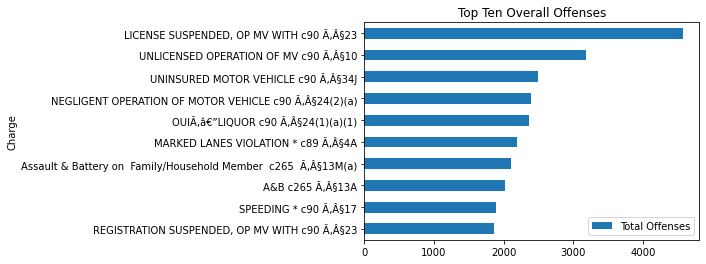

In [98]:
# TOP TEN OVERALL OFFENSES
overall_offenses = nw.groupby(['Charge'])['Charge'].count().reset_index(name='Total Offenses').sort_values(['Total Offenses'], ascending=False)
overall_offenses.head(10).sort_values(['Total Offenses'], ascending=True).plot.barh(x='Charge', title='Top Ten Overall Offenses')

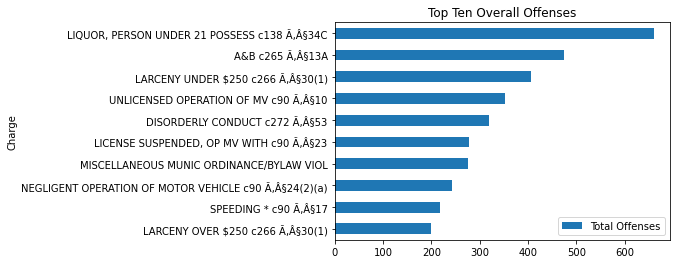

In [99]:
# TOP TEN JUVENILE OFFENSES
juvenile_offenses = nw[(~nw['Age at Offense'].isnull()) & (nw['Age at Offense']<21)].groupby(['Charge'])['Charge'].count().reset_index(name='Total Offenses').sort_values(['Total Offenses'], ascending=False)
juvenile_offenses.head(10).sort_values(['Total Offenses'], ascending=True).plot.barh(x='Charge', title='Top Ten Overall Offenses')

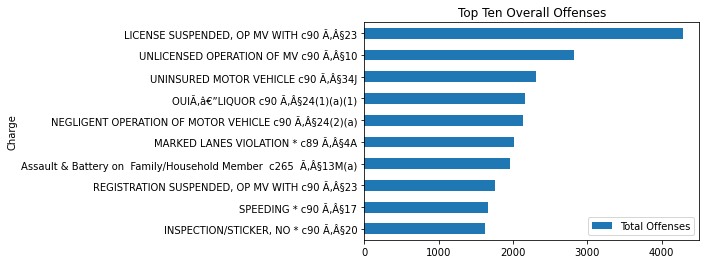

In [100]:
# TOP TEN ADULT OFFENSES
adult_offenses = nw[(~nw['Age at Offense'].isnull()) & (nw['Age at Offense']>=21)].groupby(['Charge'])['Charge'].count().reset_index(name='Total Offenses').sort_values(['Total Offenses'], ascending=False)
adult_offenses.head(10).sort_values(['Total Offenses'], ascending=True).plot.barh(x='Charge', title='Top Ten Overall Offenses')